# Understanding Mall customers

In this exercise, you work for a consulting firm as data scientist. In this scenario, your client is the owner of a Mall and he wants to understand the customers who can easily buy.  

You dispose of a dataset from the mall dataset with 5 features :
- CustomerID of the customer
- Gender of the customer
- Age of the customer
- Annual Income of the customer in k$
- Spending Score assigned by the mall based on customer behavior and spending nature (1-99)

You have one day to perform this analysis

In [450]:
# pip install yellowbrick

In [451]:
#Import librairie 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline   
import plotly.express as px 

import plotly.graph_objs as go
import plotly as py


import warnings
warnings.filterwarnings('ignore')

In [452]:
df = pd.read_csv('../data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# EDA

In [453]:
df.shape

(200, 5)

In [454]:
# Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [455]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [456]:
# sum of NaN
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [457]:
# Checking for Duplicates
print(sum(df.duplicated()))
df = df.drop_duplicates()

0


In [458]:
#Renaming Columns
df.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Spending_score'}, inplace=True)
df.head(3)

,CustomerID,Gender,Age,Income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [459]:
# Dropping the Customer ID Column
df.drop('CustomerID',axis=1,inplace=True)

## Univariate Analysis

### Gender

In [460]:
df["Gender"].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

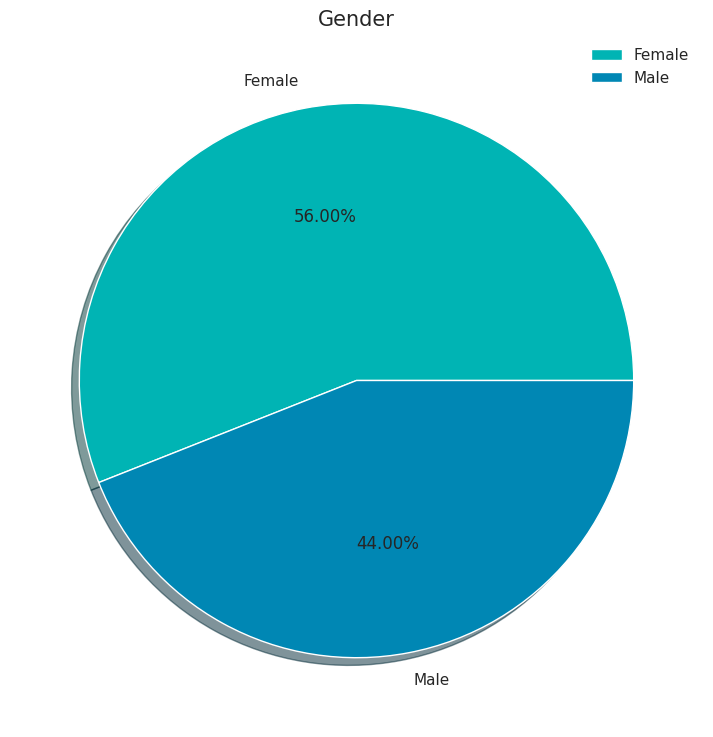

In [461]:
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['#00b4b4', '#0087b4']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

In [462]:
# def summarize_by_gender(df, gender):
#     gender_df = df[df['Gender'] == gender]
#     cols = ['Age', 'Income', 'Spending']
    
#     for col in cols:
#         print(f"Max {gender} {col.lower()}: {gender_df[col].max()}")
#         print(f"Min {gender} {col.lower()}: {gender_df[col].min()}")
#         print(f"Mean {gender} {col.lower()}: {gender_df[col].mean()}")
#         print(f"Std {gender} {col.lower()}: {gender_df[col].std()}")

In [463]:
def summarize_by_gender(df, gender):
    gender_df = df[df['Gender'] == gender]
    cols = ['Age', 'Income', 'Spending_score']
    summary = []
    
    for col in cols:
        summary.append({('Variable ' + gender ) : col, 
                        'Max': gender_df[col].max(), 
                        'Min': gender_df[col].min(), 
                        'Mean': gender_df[col].mean(), 
                        'Std': gender_df[col].std()})
    
    return pd.DataFrame(summary)

In [464]:
summarize_by_gender(df, 'Male')

,Variable Male,Max,Min,Mean,Std
0,Age,70,18,39.806818,15.514812
1,Income,137,15,62.227273,26.638373
2,Spending_score,97,1,48.511364,27.896770


In [465]:
summarize_by_gender(df, 'Female')

,Variable Female,Max,Min,Mean,Std
0,Age,68,18,38.098214,12.644095
1,Income,126,16,59.250000,26.011952
2,Spending_score,99,5,51.526786,24.114950


### Exploring the Age Column for Further Analysis

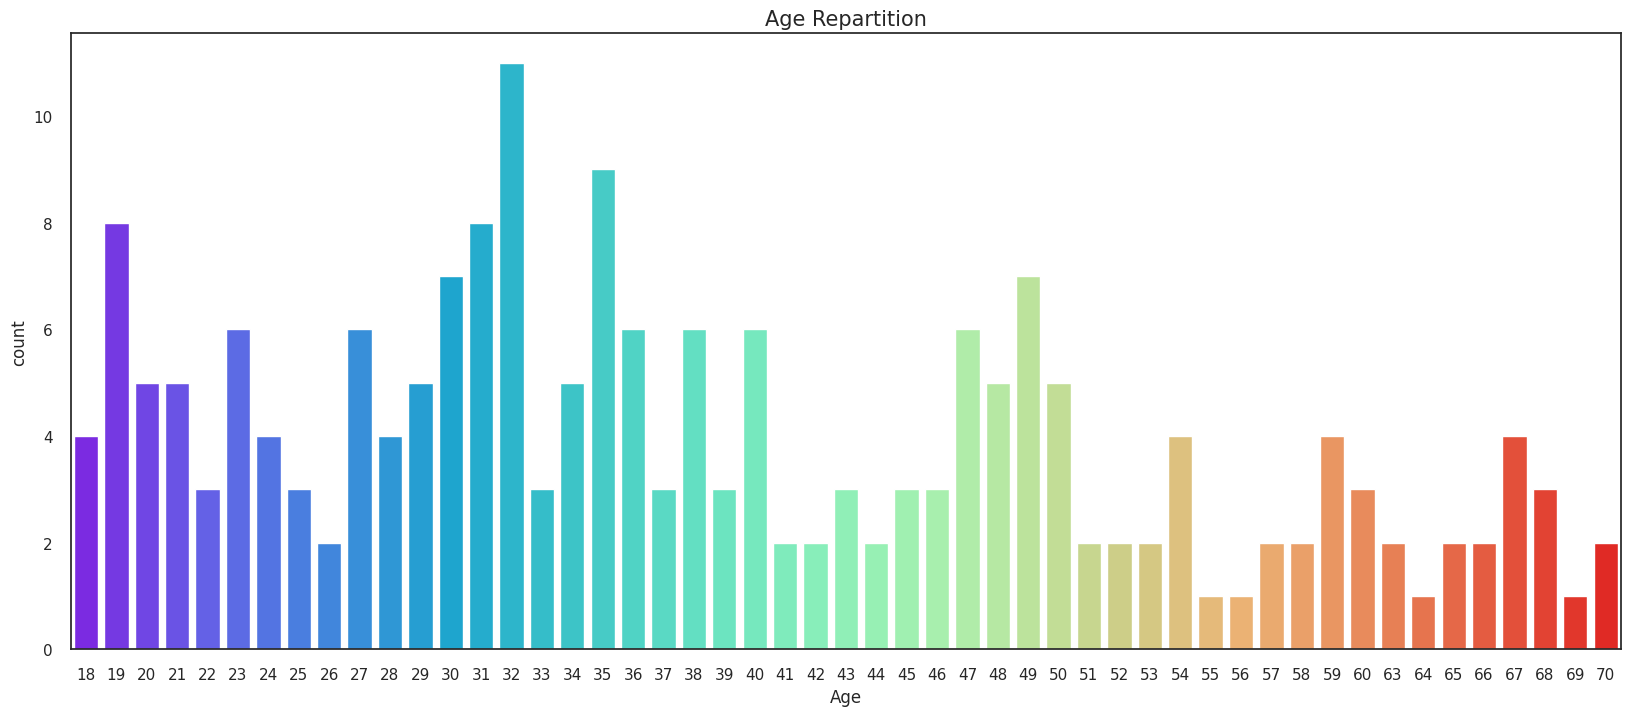

In [466]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.countplot(df['Age'], palette = 'rainbow')
plt.title('Age Repartition', fontsize = 15)
plt.show()

In [467]:
df.Age.unique()

array([19, 21, 20, 23, 31, 22, 35, 64, 30, 67, 58, 24, 37, 52, 25, 46, 54,
       29, 45, 40, 60, 53, 18, 49, 42, 36, 65, 48, 50, 27, 33, 59, 47, 51,
       69, 70, 63, 43, 68, 32, 26, 57, 38, 55, 34, 66, 39, 44, 28, 56, 41])

In [468]:
print(len(df.Age.unique()))

51


In [469]:
df.Age.value_counts()[:10]

32    11
35     9
19     8
31     8
30     7
49     7
40     6
38     6
47     6
27     6
Name: Age, dtype: int64

### Creating an Age Range Category

In [470]:
# Creating new category
bins = [18, 22, 50, 70]
labels = ['Young', 'Adult', 'Senior']
df['Age Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df.head()

,Gender,Age,Income,Spending_score,Age Range
0,Male,19,15,39,Young
1,Male,21,15,81,Young
2,Female,20,16,6,Young
3,Female,23,16,77,Adult
4,Female,31,17,40,Adult


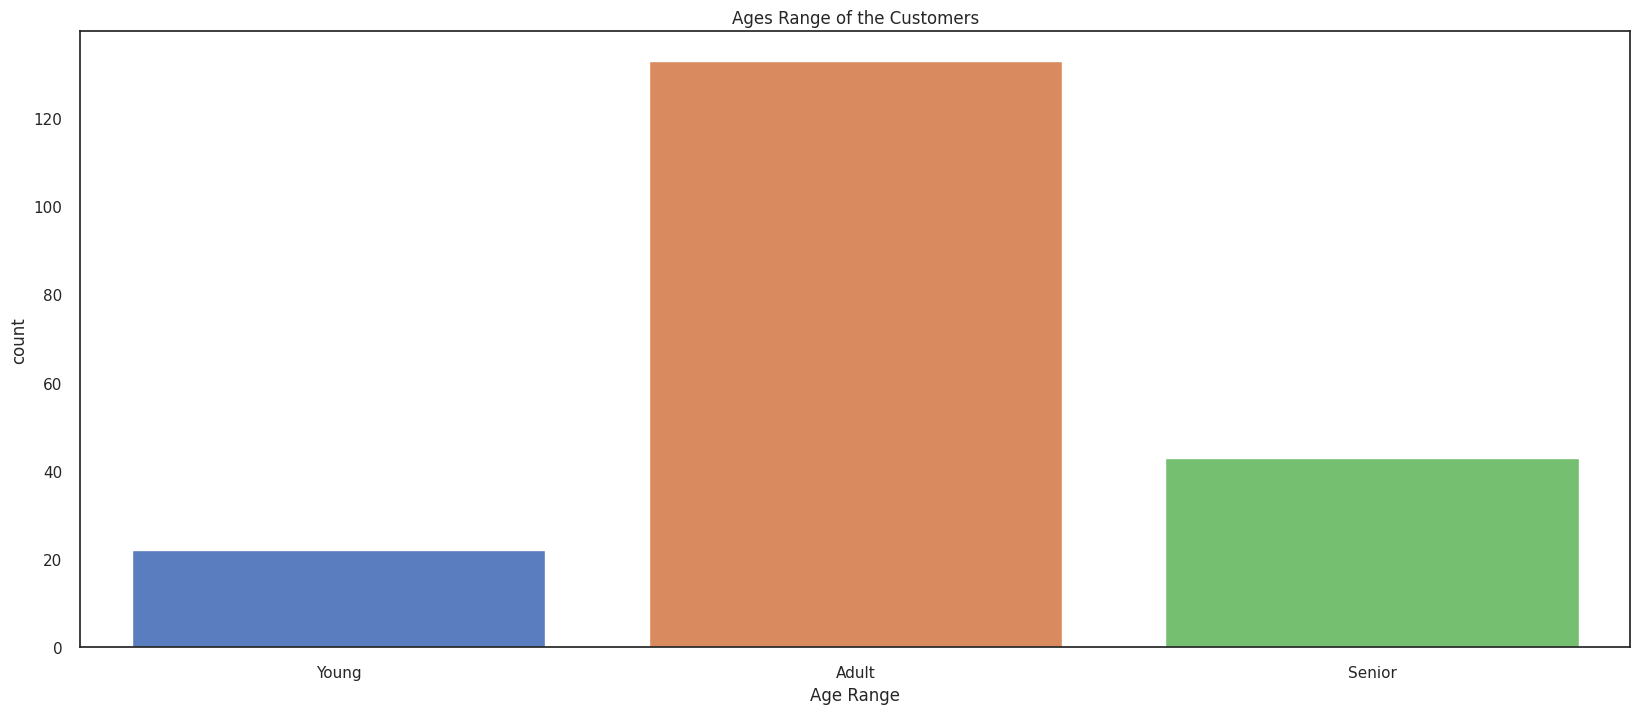

In [471]:
sns.countplot(df['Age Range'])
plt.title('Ages Range of the Customers')
plt.show()

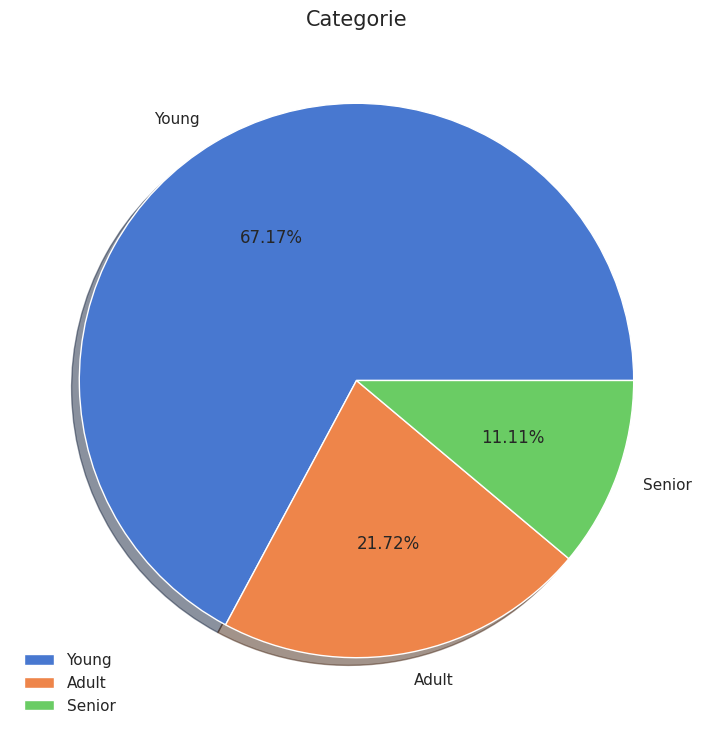

In [472]:
labels = ['Young', 'Adult', 'Senior']
size = df['Age Range'].value_counts()
# colors = ['#00b4b4', '#0087b4']
explode = [0, 0.1, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Categorie', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

In [473]:
df['Age Range'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Adult     67.17%
Senior    21.72%
Young     11.11%
Name: Age Range, dtype: object

In [474]:
# plt.title('First Popular Ages of the Customers')
# sns.barplot(x='Age Range',y='Income')
# plt.xlabel('Ages')
# plt.ylabel('Total AnnualIncome')
# plt.show()

In [475]:
df.Age.value_counts()[:3]

32    11
35     9
19     8
Name: Age, dtype: int64

In [476]:
AnnualIncome_age_32=0
AnnualIncome_age_35=0
AnnualIncome_age_19=0

AnnualIncome_age_32=sum(df[df['Age']==32].Income)
AnnualIncome_age_35=sum(df[df['Age']==35].Income)
AnnualIncome_age_19=sum(df[df['Age']==19].Income)

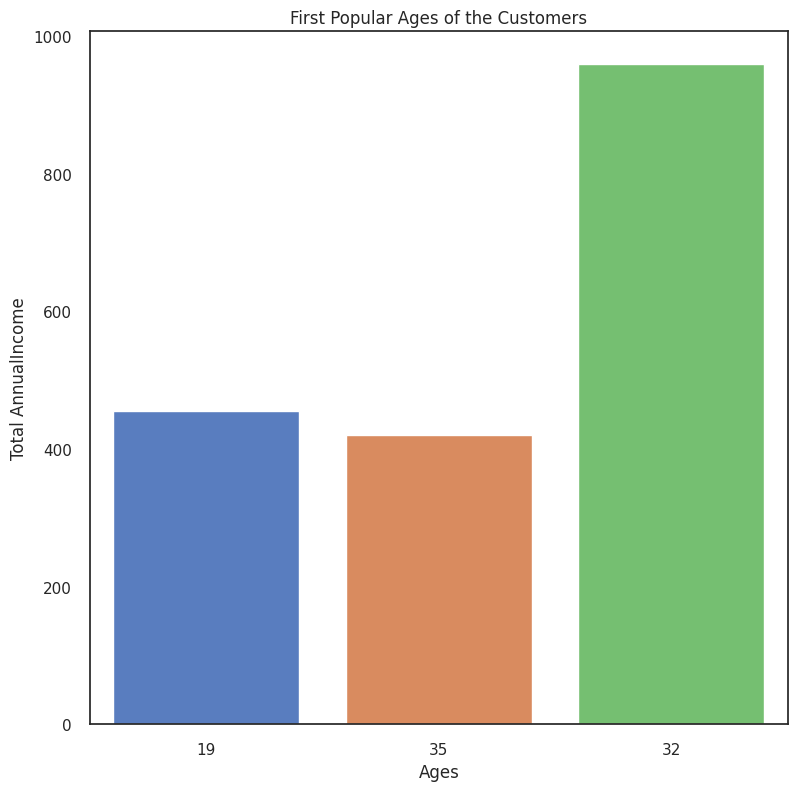

In [477]:
plt.title('First Popular Ages of the Customers')
sns.barplot(x=['19','35','32'],y=[AnnualIncome_age_19,AnnualIncome_age_35,AnnualIncome_age_32])
plt.xlabel('Ages')
plt.ylabel('Total AnnualIncome')
plt.show()

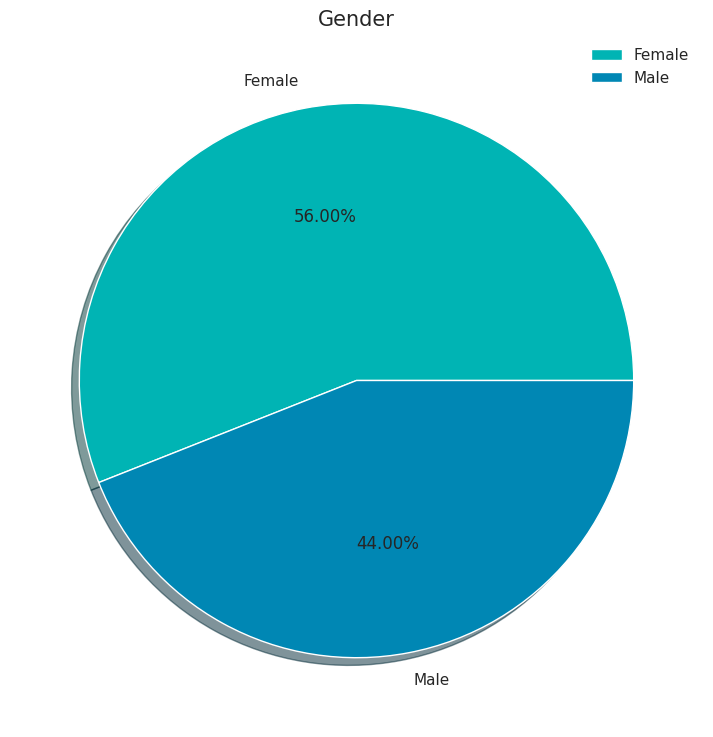

In [478]:
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['#00b4b4', '#0087b4']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 15)
plt.axis('off')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Density'>

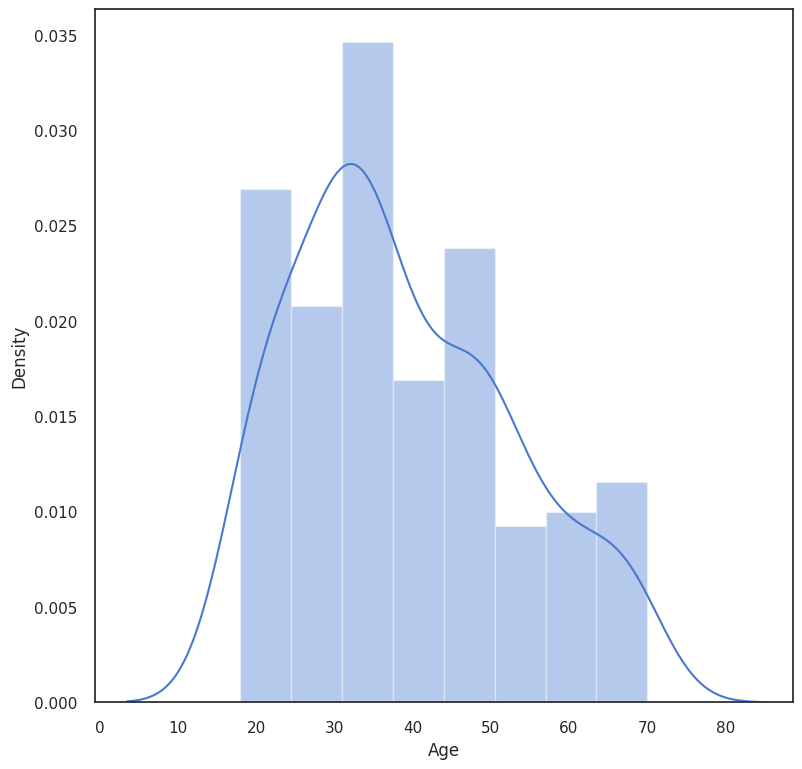

In [479]:
sns.distplot(df["Age"])

<AxesSubplot:xlabel='Income', ylabel='Density'>

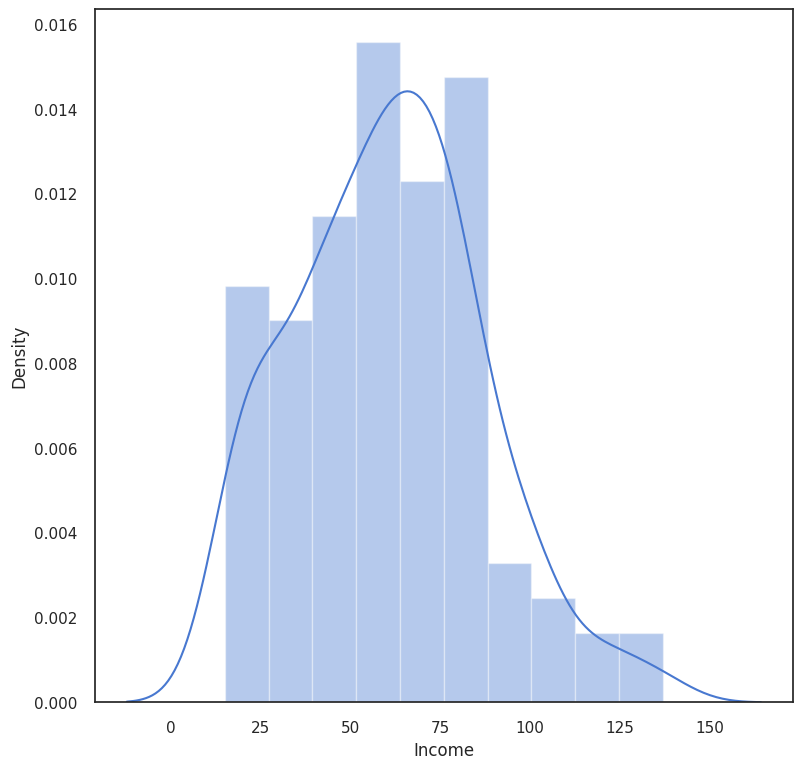

In [480]:
sns.distplot(df["Income"])

<AxesSubplot:xlabel='Spending_score', ylabel='Density'>

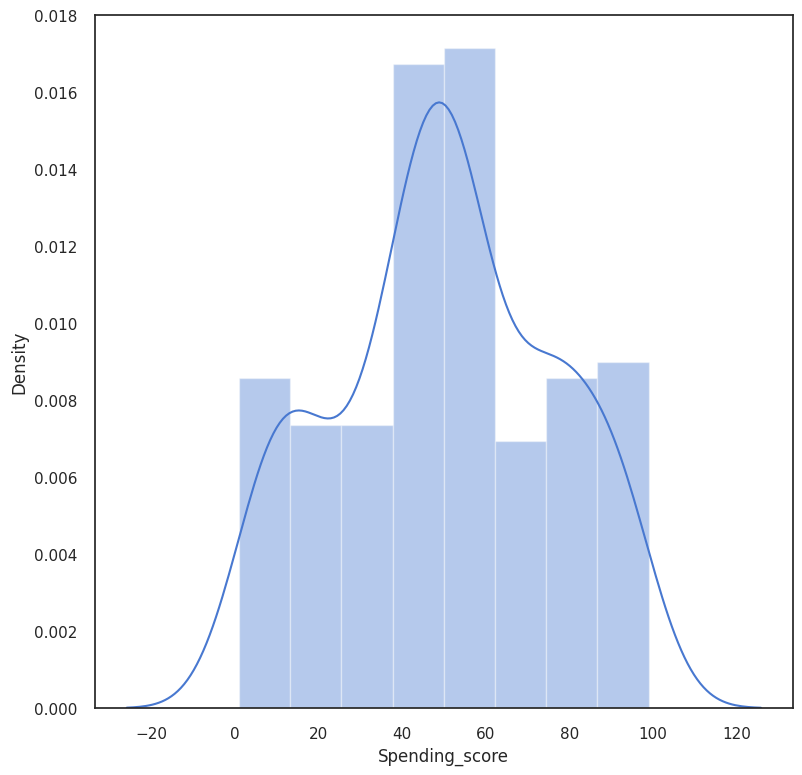

In [481]:
sns.distplot(df["Spending_score"])

## Bivariate Analysis

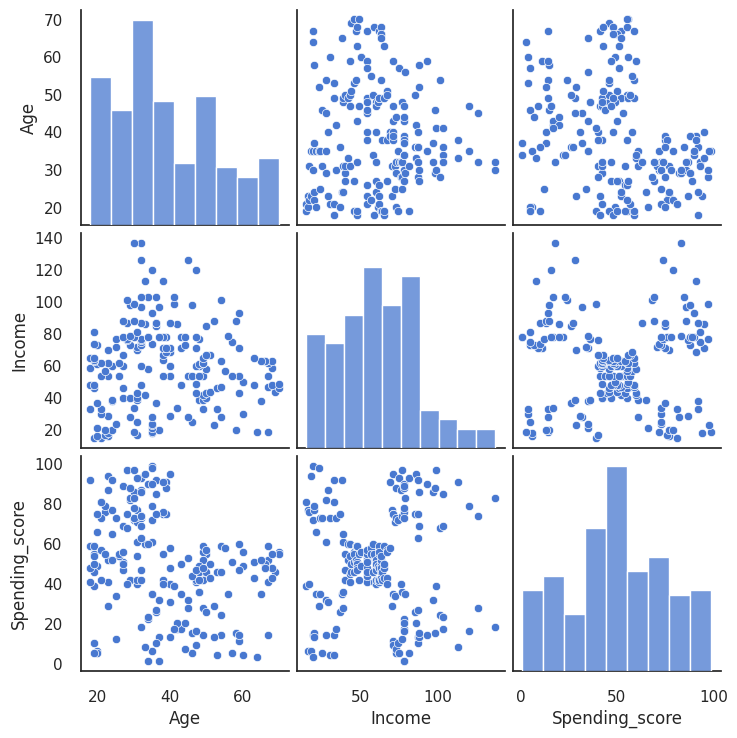

In [482]:
sns.pairplot(df)

<!-- <div class="alert alert-info">
Observations:<br>
<br>
Most of the customers are in the 20-40 age group.<br>
Spending score is high for the customers in the age group of 20-40.<br>
Spending score is high for customers with very low and very high income.<br>
</div> -->

<AxesSubplot:>

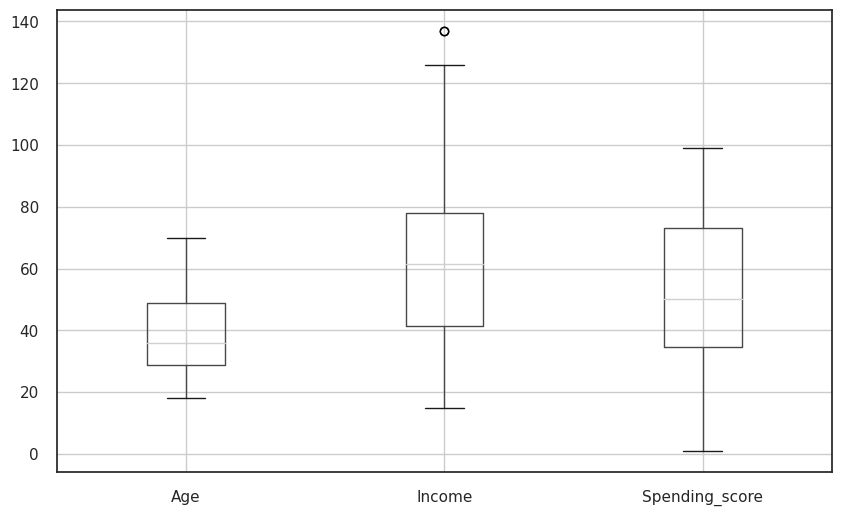

In [483]:
# view
plt.figure(figsize=(10,6))
df.boxplot()

In [484]:
outliers = df.loc[df['Income'] > 126] 

<div class="alert alert-info">
We note 2 outliers in the Income function but they are not aberration.
</div>

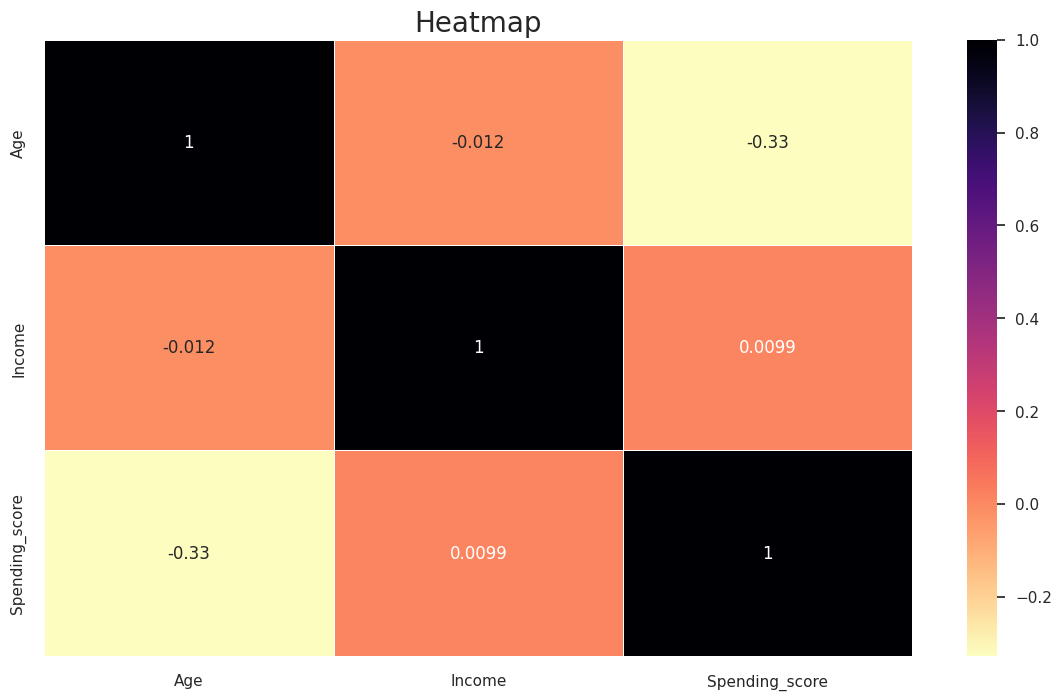

In [485]:
plt.rcParams['figure.figsize'] = (14, 8)
sns.heatmap(df[[ 'Gender', 'Age', 'Income','Spending_score']].corr(), cmap = 'magma_r', annot = True, linewidths=.5)
plt.title('Heatmap', fontsize = 20)
plt.show()

<div class="alert alert-info">
As we can see there is not much correlation between the features.
</div>

Text(4.694444444444445, 0.5, 'Spending Score')

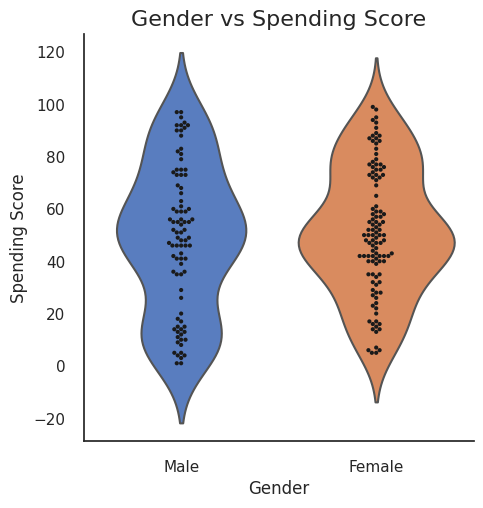

In [486]:
plt.rcParams['figure.figsize'] = (16, 7)
g = sns.catplot(x="Gender", y="Spending_score", kind="violin", inner=None, data=df)
sns.swarmplot(x="Gender", y="Spending_score", color="k", size=3, data=df, ax=g.ax);
plt.title('Gender vs Spending Score', fontsize = 16)
plt.xlabel('Gender')
plt.ylabel('Spending Score')

Text(7.819444444444445, 0.5, 'Income')

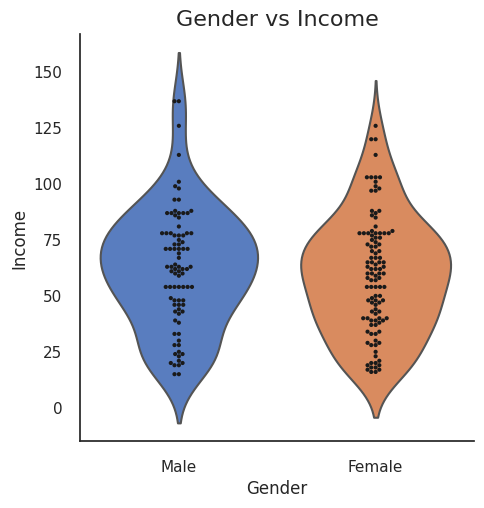

In [487]:
plt.rcParams['figure.figsize'] = (16, 7)
g = sns.catplot(x="Gender", y="Income", kind="violin", inner=None, data=df)
sns.swarmplot(x="Gender", y="Income", color="k", size=3, data=df, ax=g.ax);
plt.title('Gender vs Income', fontsize = 16)
plt.xlabel('Gender')
plt.ylabel('Income')

In [488]:
print("Mean of Annual Income of Female:",df['Income'].loc[df['Gender'] == 'Female'].mean())
print("Mean of Annual Income of Male:",df['Income'].loc[df['Gender'] == 'Male'].mean())

Mean of Annual Income of Female: 59.25
Mean of Annual Income of Male: 62.22727272727273


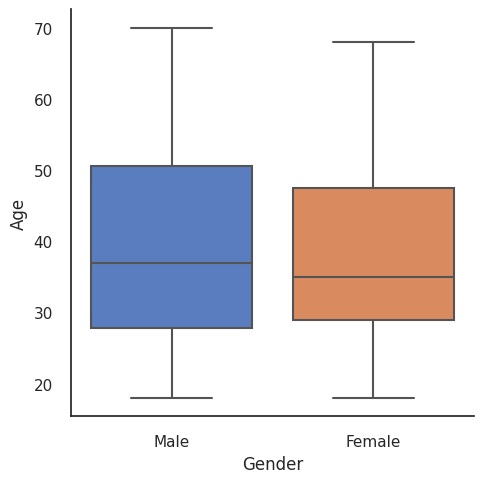

In [489]:
sns.catplot(x="Gender", y="Age", kind="box", data=df);

In [490]:
df.groupby('Gender').mean()

,Age,Income,Spending_score
Gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


## Encoding

In [491]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
df['Gender']= label_encoder.fit_transform(df['Gender'])
 
df['Gender'].unique()

array([1, 0])

In [492]:
df.head()

,Gender,Age,Income,Spending_score,Age Range
0,1,19,15,39,Young
1,1,21,15,81,Young
2,0,20,16,6,Young
3,0,23,16,77,Adult
4,0,31,17,40,Adult


### Nunmerical Features Distribution

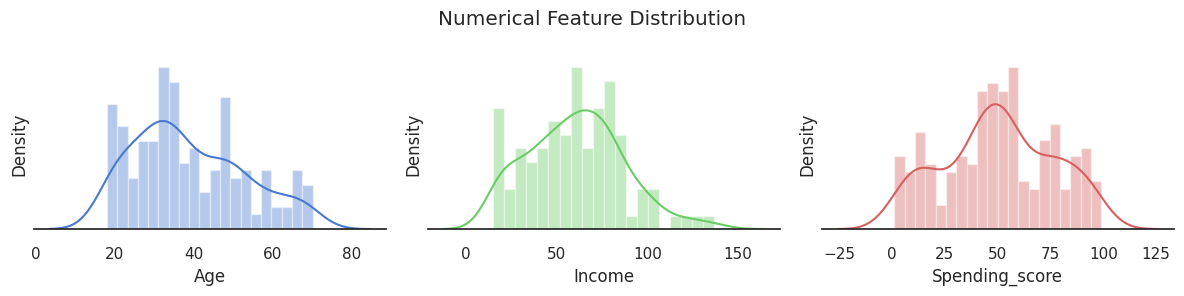

In [493]:
# Numerical features distribution
sns.set(style='white', palette='muted', color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.despine(left=True)
axs[0] = sns.distplot(df['Age'], bins=20, ax=axs[0])
axs[1] = sns.distplot(df['Income'], bins=20, ax=axs[1], color='g')
axs[2] = sns.distplot(df['Spending_score'], bins=20, ax=axs[2], color='r')

fig.suptitle('Numerical Feature Distribution')
plt.setp(axs, yticks=[])
plt.tight_layout()
plt.show()
     

<div class="alert alert-info">
We note 2 outliers in the Income function but they are not aberration.
</div>

# Customer Segmentation using different clustering methods

Try to perform different Clustering methods (e.g. k-means, agglomerative, DBSCAN, Gaussian) to create clusters and understand behaviors

https://machinelearningmastery.com/clustering-algorithms-with-python/

https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

## Hierarchical Clustering

### Agglomerative

<div class="alert alert-info">
We will be looking at a clustering technique, which is Agglomerative Hierarchical Clustering. Agglomerative is the bottom up approach which is more popular than Divisive clustering.

We will also be using Complete Linkage as the Linkage Criteria.

The Agglomerative Clustering class will require two inputs:

n_clusters: The number of clusters to form as well as the number of centroids to generate.

linkage: Which linkage criterion to use. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

Value will be: 'complete'

Note: It is recommended that try everything with 'average' as well
</div>

Il s'agit d'une approche de clustering « de bas en haut » : chaque observation commence dans son propre groupe et les paires de groupes sont fusionnées au fur et à mesure que l'on monte dans la hiérarchie.

In [494]:
from sklearn.cluster import AgglomerativeClustering 

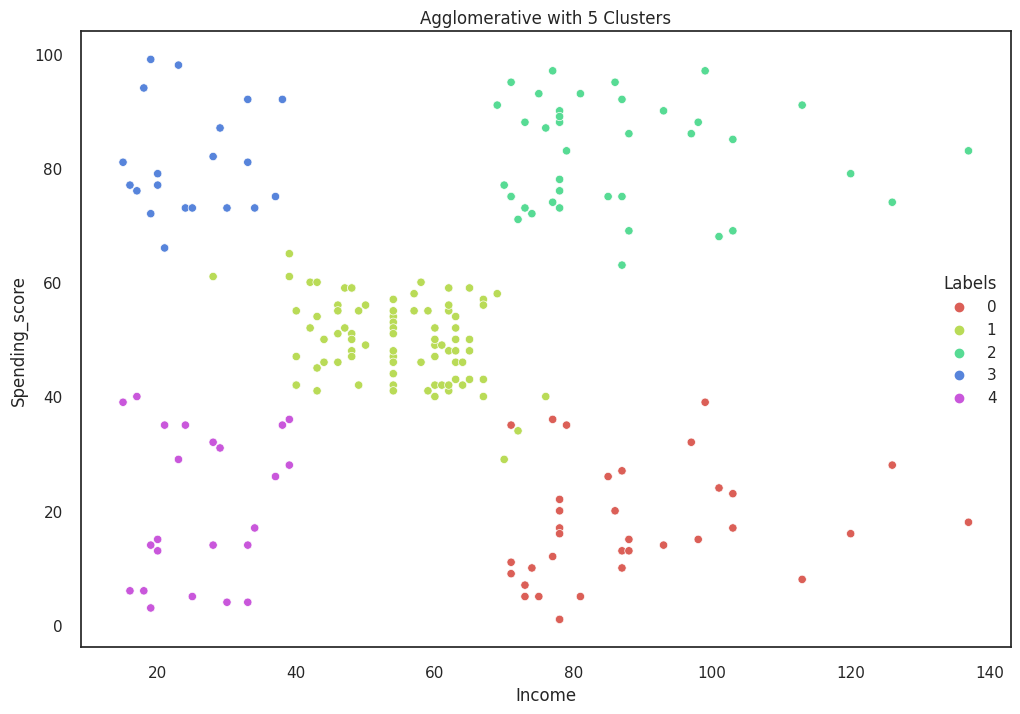

In [495]:
from sklearn.cluster import AgglomerativeClustering 

dataset = df[['Gender','Age','Income','Spending_score']]

agglom = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(dataset)

dataset['Labels'] = agglom.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(dataset['Income'], dataset['Spending_score'], hue=dataset['Labels'], 
                palette=sns.color_palette('hls', 5))
plt.title('Agglomerative with 5 Clusters')
plt.show()

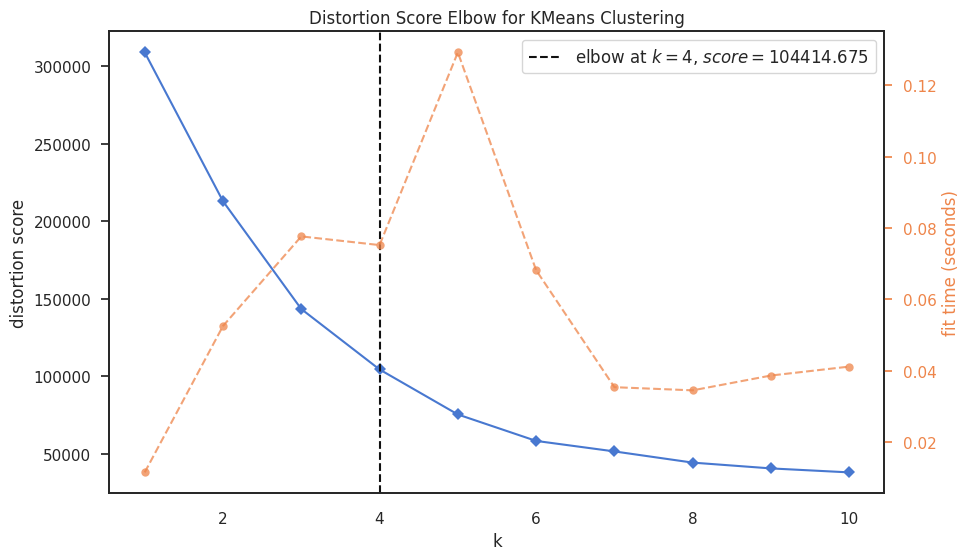

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [496]:
# define features
X_elbow = df[['Gender','Age','Income','Spending_score']]

#plot elbow
plt.figure(figsize=(10,6))
model_km = KMeans(random_state=4)
visualizer = KElbowVisualizer(model_km, k =(1,11))
visualizer.fit(X_elbow)
visualizer.show()

In [497]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)

In [498]:
# define features
X = df[['Gender','Age','Income','Spending_score']]

# define cluster
model = AgglomerativeClustering(n_clusters=5)

# fit the model
pred = model.fit_predict(X)

# silhouette score
silhouette_score(X, pred)

0.43997527212476695

In [500]:
# new column "cluster" in dataset df_cluster
df_cluster= df[['Gender','Age','Income', 'Spending_score','cluster']]
df_cluster['cluster']= pred
df_cluster.head()

KeyError: "['cluster'] not in index"

In [ ]:
# visualisation agglomerative clustering
plt.figure(figsize=(6,6))
plt.scatter(df_cluster['Income'],df_cluster['Spending_score'],c=pred, cmap="rainbow")
plt.xlabel('Income')
plt.ylabel('Spending_score')

In [ ]:
# import scipy.cluster.hierarchy as sch
# dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
# plt.title('Dendrogam', fontsize = 20)
# plt.xlabel('Customers')
# plt.ylabel('Ecuclidean Distance')
# plt.show()

In [501]:
df_cluster.groupby('cluster').mean()

,Gender,Age,Income,Spending_score
cluster,,,,
0,0.397590,42.156627,54.759036,49.771084
1,0.571429,41.685714,88.228571,17.285714
2,0.461538,32.692308,86.538462,82.128205
3,0.400000,24.850000,24.950000,81.000000
4,0.391304,45.217391,26.304348,20.913043


In [ ]:
df_cluster.groupby('cluster').count()

In [ ]:
# # Pairplot
# sns.pairplot(df_cluster,hue='cluster', palette="mako")

## K-means 

In [502]:
df_k = df[['Gender', 'Age', 'Income','Spending_score']]

In [503]:
df_k 

,Gender,Age,Income,Spending_score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [510]:
model = KMeans(n_clusters=6, random_state=42).fit(df_k)
centers = model.cluster_centers_
pred = model.fit_predict(df_k)
silhouette_score(df_k ,pred)

0.4539568684490048

In [509]:
df_k['cluster'] = model.labels_
fig = px.scatter_3d(df, x='Income',y='Spending_score',z='Age',color='cluster', opacity=0.8)
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['Gender', 'Age', 'Income', 'Spending_score', 'Age Range'] but received: cluster

In [511]:
df_k['cluster'].value_counts()

1    45
0    39
4    38
3    35
2    22
5    21
Name: cluster, dtype: int64

In [ ]:
df_k['cluster'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

In [ ]:
df_k['cluster']= df_k['cluster'].replace(to_replace={0 : "Pas Cible", 1 : "Persona", 2 : "Senior potentiel", 3 : "Cible Primaire", 4 : "Junior Potentiel", 5 :"Promissing"}, inplace =True)

In [ ]:
df_k['cluster']

In [ ]:
df.groupby('cluster').mean()

In [ ]:
df_k.groupby('cluster').mean()

In [ ]:
Senior_potentiel= df_k[(df_k['cluster'] == "Senior potentiel") ]
Senior_potentiel = pd.DataFrame(Senior_potentiel.mean())
Senior_potentiel

In [ ]:
df_k.groupby('cluster').mean()

In [ ]:
df_k.groupby('cluster').count()

In [ ]:
df_k df[df['order_status'] != "delivered"].shape

In [ ]:
sns.pairplot(df_km, hue = 'cluster')

Après avoir reporté les résultats obtenus par K-means sur ce graphique 3D, il nous appartient maintenant d'identifier et de décrire les cinq clusters qui ont été créés :

Grappe jaune - La grappe jaune regroupe des jeunes à revenu annuel modéré à faible qui dépensent beaucoup.
Cluster violet - Le cluster violet regroupe des personnes raisonnablement jeunes avec des salaires assez décents qui dépensent beaucoup.
Cluster rose - Le cluster rose regroupe essentiellement des personnes de tous âges dont le salaire n'est pas assez élevé et dont le score de dépenses est modéré.
Orange Cluster - Le cluster orange regroupe des personnes qui ont en fait de très bons salaires et dépensent à peine de l'argent, leur âge se situe généralement entre trente et soixante ans.
Groupe bleu - Les groupes du groupe bleu dont le salaire est assez bas et ne dépensent pas beaucoup d'argent dans les magasins, ce sont des personnes de tous âges.

# Conclusions

En utilisant le clustering k-means, nous avons réussi à former différents clusters basés sur différentes caractéristiques. La direction du centre commercial peut cibler les clusters avec un score de dépenses moyen pour augmenter leurs bénéfices et doit également maintenir de bonnes relations avec les clients premium avec un score de dépenses élevé. Ils doivent également travailler à trouver de nouvelles idées innovantes pour améliorer les clients avec un score de dépenses faible.